# Discussion Note
# Classification and representation of open-ended and unrestricted `ethnicity` and `language`-related response formats

Written by the OSCE High Commission on National Minorities

For questions, please contact: Peter Naderer at [peter.naderer@osce.org](mailto:peter.naderer@osce.org)

> **How to read this document:** This document is a Jupyter Notebook that allows to combine narrative text and code for statistical programming (in this case Python). The document is written with a view of making each step of the paper transparent and reproducible. It includes both narrative parts, as well as code using the Python programming language. > This Jupyter notebook provides a practical overview of how a variables related to `ethnicity` and `language` can be prepared and visualized in a conflict-sensitive and human rights compliant manner. The notebook can be fully reproduced using the printed Python code with the libraries indicated below.
> **If you want to see the code, you can click on the cells that are collapsed.**
> For the purpose of this document, we will use two distinct sources of data.
>
> 1. The **Population and Housing Census of Moldova** for the yeras of **2004** and **2014** Census obtained from the National Bureau of Statistics on ethnicity and language. In particular we are going to use the statistical table titled: ["Caracteristici - Populație 1 (populația pe raioane, sexe, vârste, etnie, limba maternă, limba vorbită)"](https://statistica.gov.md/files/files/Recensamint/Recensamint_pop_2014/Rezultate/Tabele/Caracteristici_populatie_RPL_2014_rom_rus_eng.xls) 
> 2. The [raw data](https://www.hcnmplatform.org) of the HCNM's **Ethnobarometers 2020**, which is a two-stage cluster survey designed to research ethnicity and language usage in Moldova.
> 3. An estimation of Moldova's population in 2024 dissaggregated by ethnicity, based on 2004 and 2014 data. In order to obtain **purely hypothetical** data, we perfrom an exponential regression on population statistics to estimate values for 2024. We use $ln(Y) = ln(b_0) + b_1 X$. Where: $Y$ is the target, i.e. the population count, $b_0$ is the intercept, $b_1$ is the slope for $X$, which is the predictor, i.e. the year

In [111]:
# Load required libaries for the notebook
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import contextily as ctx
import os
from pyaxis import pyaxis
import requests

In [112]:
# Loading 2004 and 2014 Census data from from the National Bureau of Statistics

url = "https://statistica.gov.md/files/files/Recensamint/Recensamint_pop_2014/Rezultate/Tabele/Caracteristici_populatie_RPL_2014_rom_rus_eng.xls"
response = requests.get(url)

# with open('Caracteristici_populatie_RPL_2014_rom_rus_eng.xls', 'wb') as f:
#     f.write(response.content)

# Load raw data on 'ethnicity' downloaded from NBS
df = pd.read_excel(response.content, sheet_name="7")

# Cleaning dataset
df = df.iloc[10:27, 0:3]
df.columns = ['ethnicity', '2004', '2014']
df = df[df['2004'].notna()]
df.reset_index(drop=True, inplace=True)
df['ethnicity'][8] = df['ethnicity'][8][15:34]

eng_names = {'Bulgari': 'Bulgarian', 'Găgăuzi': 'Gagauz', 'Moldoveni': 'Moldovan', 'Roma': 'Roma', 
             'Români': 'Romanian', 'Ruşi': 'Russian', 'Ucraineni': 'Ukrainian', 
             'Alte etnii': "Others", 'nu a declarat etnia': "Not declared"}

df['ethnicity'] = df['ethnicity'].replace(eng_names)

In [113]:
# Loading Etnobarometer data and variable names

df_e = pd.read_excel('../pandas/etnobarometer/3_ETNO_database_final_REORDERED_Version 6_EN.XLSX',
                     sheet_name='ETNO_database_final_text data')
vars_e = pd.read_excel(
    '../pandas/etnobarometer/3_ETNO_database_final_REORDERED_Version 6_EN.XLSX', sheet_name='New structure')

vars_e.columns = ('variable', 'text')
vars_e.index = vars_e['variable'].reset_index(drop=True)
vars_e = vars_e.drop('variable', axis=1)

# Extract needed data on ethnic self-identification
df_e_ethnicity = df_e.loc[:, ["ETHN-GROUP", "Q2_01", "Q2_02",
                              "Q2_03", "Q2_04", "Q2_05", "Q2_06", "Q2_07", "Q2_08", "Q2_09"]]
# Transform into numerical values to allow for suming
df_e_ethnicity.replace({'Yes': 1, 'No': 0}, inplace=True)

In [114]:
# Estimateing 2024 population by ethnic group
# 
#  We start by creating a `dataframe` with exisiting official data on `ethnicity` and then estimate the population data by ethnicity for the year `2024` using a exponential regression.

# Define years for x-axis
years = np.array([2004, 2014]).reshape(-1, 1)

# Exponential regression
for i in range(df.shape[0]):
    pop = df.loc[i, ['2004', '2014']].values.astype(float)
    pop_log = np.log(pop)
    model_exp = LinearRegression()
    model_exp.fit(years, pop_log)
    prediction_2024 = np.exp(model_exp.predict(np.array([[2024]])))
    df.loc[i, '2024'] = prediction_2024.round(0)

df.index = df['ethnicity']

# Estimated population for Moldova in 2024
df['2024_p'] = df[['2024']].apply(lambda x: x / sum(x))

# Key arguments

* **Almost 40% of Moldovans are likley to indicate multiple identities:** If given the possiblity, there is a significant likelihood that almost 40% of all residents of Moldova would self-identify with two or more ethnic groups. In regards to language more than *XX*% would indicate knowing more than one language on the level of a native speaker.
* **Allowing for multiple identities on both ethnicities and languages is conflict-sensitive and a human rights obligation:** Restricting response format to a specific number of responses, such as single or dual choice, is not in line with a human rights-based approach to data as well as the primacy of voluntary self-identification.
* A combination of **"Total response grouping"  and "Single/combination grouping" recommended for ethnic classification in Moldova:** While there are a number of internationally employed methods to classify multiple ethnicities, only few are in line with a human rights-based approach to data and even less suitable for Population and Housing Census exercises. Classification options depend on the format of questions.
* **Two = Three and More:** Allowing for three or more responses on ethnicity questions, is technically not different from allowing only two responses. There is no technical reason for restricting responses on ethnicity questions.
* **Approach on ethnicity can be mirrored to languages:** From a statistical perspective there is no reason for restricting response formats on languages to single-choice. The same principles applied for ethnicity questions can apply to language. 

# Introduction

This discussion paper aims to showcase how to deal with multiple identities regarding both ethnicity and language in a practical and applied manner. The paper is tailored to the context of Moldova and uses specific data sources, with a view to inform the upcoming Population and Housing Census in 2024.

The paper first uses data to display the diversity of Moldova, and then discusses various forms of classifying ethnic identities used in national context around the world. The paper then proceeds to use data and show how each classification method would potentially look like in Moldova. Finally, the paper shows how the same approach used for mulitple ethnic identities can also easily be applied to

The paper shows tat **not allowing** unrestricted and open-ended answer options for questoins related to `ethnicity` and `language` during Population and Housing Census can have signifcantly distort census outcomes and render data unusable for policy makers and legislators.

# Data and conflict prevention

The OSCE High Commissioner on National Minorities (HCNM) was established in 1992 as an instrument to address tensions involving minority issues, in order to prevent conflict between or within States. The High Commissioner focuses on identifying and responding to potential divisions in society based on ethnicity, religion, language, or a combination of the three.

In recognition of the importance of these identity markers, the HCNM stresses that the availability of data that appropriately reflects society across ethnicity, religion and language is of paramount importance for enabling State authorities to develop targeted national minority policies and legislation, which in turn can contribute to the integration of diverse societies able to withstand tensions and prevent conflicts. The HCNM views Moldova’s planned Census 2024 as a crucial activity for empowering the country’s authorities to identify potential challenges and in response deliver policy and legislation for enhancing social cohesion of Moldova’s diverse society.

## The primacy of voluntary self identitication

Diversity is a feature of all contemporary societies and of the groups that comprise them.  In order to appropriately reflect such diversity it is of paramount importance to recognize “that individual identities may be multiple, multilayered, contextual and dynamic”.   Furthermore, individual identities must always subject to the primacy of individual choice through the principle of voluntary self‑identification. 
A census that does not allow for multi-choice format on questions related to ethnicity cannot be in compliance with the primacy of voluntary self-identification.

Single ethnic identification can be constraining and lead to incomplete or inaccurate data, as a significant number of individuals may identify as belonging to more than one ethnic group. Leading them to choose only one can amount to a misrepresentation of their cultural background and identity. HCNM considers such an approach as potentially harmful, as it may reinforce societal cleavages.

In comparison, a census can capture the diversity of the population and provide an accurate representation of the country's demographics by allowing for multiple ethnic identification. Then the census can also promote a sense of belonging and inclusivity among individuals from diverse ethnic backgrounds, conveying a message that all identities are valued and acknowledged.

While the simplicity of representing ethnicity and languages as a single choice may be convenient for data creators and respond to how many data users expect such data, representing ethnicity in such terms is fundamentally wrong an can in no circumstances be a suitable approximation for reality.

## Legal underpinnings

The HCNM notes that there is an implicit as well as explicit legal obligation of Moldova to ensure that census data is disaggregated by ethnicity in full compliance with the primacy of voluntary self-identification.

Moldova has ratified almost all major international human rights treaties and therefore has assumed an obligation to respect, protect and fulfil the right to equality. The latter element - the obligation to fulfil - entails that the right to equality is understood as a positive obligation. This obligation gives rise to an obligation to adopt positive measures designed to address (historic) disadvantages and ensure that everybody can participate on an equal basis. This implies an implicit obligation for collecting and employing data that establishes the knowledge base for ensuring appropriate positive action.

The HCNM also notes that by virtue of Article 31 of the Convention on the Rights of Persons with Disabilities, State parties to the Convention, such as Moldova, have an explicit obligation to "undertake to collect appropriate information, including statistical and research data, to enable them to formulate and implement policies" and to ensure that collected information "shall be disaggregated, as appropriate, and used to help assess the implementation of States Parties' obligations."

The HCNM also highlights that the global indicator framework for the Sustainable Development Goals and targets of the 2030 Agenda for Sustainable Development emphasizes the overarching principle of data disaggregation, including by income, sex, age, race, ethnicity, migratory status, disability and geographic location, and other characteristics, in accordance with the Fundamental Principles of Official Statistics. 



# Making the case for multiple identities

We woud like to start this discussion by showing the unique diversity of Moldova. Unfortuantly, this is not possible using Moldova's official statistics. Moldova's Census data for 2004 and 2014 only represents a single choice option for ethnicity and are therefore a suboptimal metric for displaying diversity. We are going to use data from the OSCE HCNM's administered **Ethnobarometer 2020** - a two-stage cluster survey on ethnicity and 
language in Moldova. The survey sample was drawn for the largest ethnic grups of the country (based on Census 2014 data), creating seven uniform sample clusters, with a view to learn about in-group diversity and inter-group diversity.

The Ethnobaromter asked two specific questions on ethnicity identity. Respondents were first asked to indicate the ethnic identity that they feel is *dominant*, with one answer option possible. This was followed with a question about possible belonging to another group or other groups. The Ethnobaromter did so with a view to ensure self-prioritizatoin of main (or best, primary, or dominant) ethnic identity. This is an approach sometimes used in research to ensure that respondents take time to think about their ethnic identity in more complex terms. It is important to stress that ideally the question sequence should have been reversed in the Ethnobarometer. First a question on indicating all ethnic groups and then defining which one is considered to be the main group, while allowing non-response on the second question. This ensures that a person that may not feel that there is a "main ethnicity" is not coerced into choosing one over the other.

> **Nota Bene:** A single question on ethnicity (as proposed for the Census 2024) is likley not to generate the same amount of multiple identifications. If not prompted specifically to think about multiple identities (even if the question is formulated to include plural), respondents are likley to reiterate previous thinking on ethnicity in single-choice terms. It is therefore important that ethnicity-related questions make clear that more than one responses is possible, ideally by way of the instructer specifically highlighting this feature.

What does the Ethnobaromter tell us about multiple identities in Moldova? Weighting the sample with estimates for Molodva's population in 2024, the likley proportion of individuals identifying with more than one group is a staggering 39% (see Figure 1). New Zealand, a very diverse society, has 11.4% on this metric for example. Looking at the unweighted survey samples and analyzing in-group differences, we see that while multiple identities are most prevalanet among minority communities (up to XX% for Bulgarians), also XX% of those having indicated "Molodvan" as their dominant ethnic group have noted more than their first ethnic group.



In [109]:
### Using the Ethnobarometer to estimate proportions of persons indicating multiple identities based on 2024 estimates of the population

# The Ethnobaromter did not include data on "Others" and "Not declared". We will therefore simulate two additional sample clusters of 400 respondents for each of those categories.
new_rows = [
    ['Others'] + [0] * 8 + [1] for _ in range(400)
] + [
    ['Not declared'] + [0] * 8 + [1] for _ in range(400)
]

new_data = pd.DataFrame(new_rows, columns=df_e_ethnicity.columns)

# Concatenate existing and new data
df_e_ethnicity_grouped = pd.concat([df_e_ethnicity, new_data], ignore_index=True)

# Adding the count of identity for each row (excluding Q2_09 for None)
df_e_ethnicity_grouped['identity_count'] = df_e_ethnicity_grouped.loc[:, ~df_e_ethnicity.columns.isin(['ETHN-GROUP',"Q2_09"])].apply(sum, axis = 1)

# Creating a new DF grouped by ethnic group and counts of the numbers of identities indicated
df_e_ethnicity_grouped = df_e_ethnicity_grouped.loc[:, ['ETHN-GROUP', 'identity_count']].groupby('ETHN-GROUP').value_counts().reset_index(name = 'count')

# Merging estimated 2024 probabilities into df
df_e_ethnicity_grouped = pd.merge(df_e_ethnicity_grouped, df[['2024_p']], left_on = "ETHN-GROUP", right_on = "ethnicity")

# We adjust the sample count with the estimated 2024 proportions.
df_e_ethnicity_grouped['weighted_count'] = df_e_ethnicity_grouped['count'] * df_e_ethnicity_grouped['2024_p']

# Creating a column that normalizes the weighted count, within each group
df_e_ethnicity_grouped['count_normalized_within_group'] = df_e_ethnicity_grouped.groupby('ETHN-GROUP')['weighted_count'].transform(lambda x: x / x.sum())

# Creating a column that normalizes across all groups
df_e_ethnicity_grouped['count_normalized_all'] = df_e_ethnicity_grouped['weighted_count'].transform(lambda x: x / x.sum())

# Calculating the proportion of the population likley to indicate more than 1 identity
df_e_ethnicity_grouped[df_e_ethnicity_grouped['identity_count'].isin([1,2,3,4])]['count_normalized_all'].sum()

# Setting globa plot parameters

## Fonts
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans serif'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.sans-serif'] = ['Arial']

# Plotting the the proportion of the population likley to indicate more than 1 identity

df_identity_count = df_e_ethnicity_grouped.groupby('identity_count')['count_normalized_all'].sum().reset_index()
df_identity_count.index = ["One ethnic group", "Two ethnic group", "Three ethnic groups", "Four ethnic groups", "Five ethnic groups"]

plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots()

df_identity_count['count_normalized_all'].plot(ax = ax, kind = 'barh')
ax.set_xlabel("Proportion of estimated total population of Moldova in 2024")

KeyError: "None of [Index(['2024_p'], dtype='object')] are in the [columns]"

# Overview of classification approaches to dealing with multiple identies

States that have allowed for multiple identities to be indicated in Population and Housing Census exercises have developed a number of classification methods for dealing with multiple ethnicities. While there is still limited research on the effect of various classifications for analytical purpose, there is evidence that **classification matters** and that it can siginficanlty influence the validity and veracity of analysis. Furthermore, only some of the employed classififaction methods are fully in line with a human rights-based approach to data and conflict-sensitive. We therefore urge States to ensure particular care should be given to this choice. (Yao 2021)

The various approaches can be divided into (1) retention methods, i.e. retaining all details of the data and (2) reduction methods, i.e. removing or aggregating details of the collected data. The following description is an adapted and expanded version of an overview created by Esther Yao 2021.

"Classification methods that retain multiple ethnicity data preserve multiple ethnic affiliations when the data are tabulated. Their main advantage is the congruence with
respondent affiliation. However, these methods tend to pose more statistical challenges. [...] By contrast, classification methods which reduce multiple ethnic affiliations into a single ethnic grouping tend to be more attractive for some statistical procedures, but may be ethically problematic and subject to interpretative inaccuracy because such methods do not utilise all the information provided by respondents. " (Yao 2021)

| Classification                | Description                                                                                                                                                                                                                                                                                                                                          | Advantages                                                                                                                                                             | Disadvantages                                                                                                                                                            | Human-rights compliance                                                                                                                                                                                                                      |
|-------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Single/combination grouping   | Participants are counted once according to the ethnic group or combination of ethnic groups they report (e.g., a person who identified as both Moldovan and Gagauz would be classified as Moldovan/Gaguz, disregarding the order).                                                                                                                   | Nuanced insight into ethnic patterns compared to other ethnic classification methods that rely on broad ethnic groupings.                                              | unmanageably large number of subgroup permutations / some combination groupings may have sample sizes that are too small for meaningful statistical analyses.            | Yes, the approach is fully in line with the HRBAD.                                                                                                                                                                                           |
| Total response grouping       | Participants are counted in each of the ethnic groups they report. Total counts can exceed total participants because participants who report more than one ethnic group are counted more than once (e.g., a person who identifies as both Moldovan and Gagauz is classified in both the Moldovan and Gagauz ethnic groups).                         | Clear indication of the number of respondents who identify with each ethnic group / Classification of ethnic groups in more specificity with little detail lost        | Mono- and multi-ethnic responses difficult to differentiate / Sum of ethnic group counts is greater than the number of participants, leading to statistical difficulties | Yes, the approach is fully in line with the HRBAD.                                                                                                                                                                                           |
| Administrative-prioritisation | Participants who report multiple ethnic groups are assigned to a single category based on a predetermined hierarchy. For example in Aotearoa/New Zealand the hiearachy is Māori > Pacific > Asian > Other > European (e.g., a person who identifies as both European and Māori is classified as Māori, as Māori is above European in the hierarchy). | Ability to classify multiple ethnic responses into a small number of mutually exclusive categories without<br/>needing to seek additional information from respondents | ethically contentious because it is dismissive of the self-affiliation / evidence of high distortive effects of the method                                               | No, the approach clearly against the principle of voluntary self-identification and not in line with HRBAD.                                                                                                                                  |
| Self-prioritisation           | Participants who report multiple ethnic groups are asked in a follow-up question to select one ethnic group that they identify with most (e.g., a person who identifies as both Moldovan and Gagauz, and then identifies Moldovan as their main ethnic group, is classified as Moldovan)                                                             | Obtains information on priority ethnicity avoiding external determination                                                                                              | Persisiting issue of how to deal with those who do not self-prioritise / Rarely observed in population censuses                                                          | Partially, as it is a an ethical challenge to ask for prioioritization as this forces persons to elevate one ethnicity over another and conveys that multi-ethnic identity is unvalued (Sanchez 2010; Townsend, Markus, and Bergsieker 2009) |

# Demonstrating classification approaches

## Retention methods
In order to demonstrate the possiblity of indicating multiple ethnicities, we can simulate a hypothetical dataset of all Moldovan's in 2024 assuming the Census will have allowed for unlimited multiple ethnic identity choice. For this purpose, we will use the estimated proportions of ethnicity for 2024, as well as the disbritubtion of identities within groups as recorded by the **Ethnobarometer 2020**. Using this data, we can then simulate how classification for Moldova's Population and Housing Census 2024 could look like.

In [90]:
# Simulating hypothetical data for Moldova's Census 2024

## Preparing new dataframe with probabilities based on the ethnobarometer.

df_e_ptable = df_e_ethnicity

## Create new column names and rename them
new_col_names = vars_e.iloc[13:22].to_dict()['text']
new_col_names = {old: new.split(' - ')[1]
                 for old, new in new_col_names.items()}
df_e_ptable.rename(columns=new_col_names, inplace=True)

## Address faulty raw data that mixes up Q2_08 and Q2_09 with wrong translation.
df_e_ptable.rename(
    columns={'No else': 'Others', "Other": "None"}, inplace=True)

# The Ethnobaromter did not include data on "Others" and "Not declared". We will therefore simulate two additional sample clusters of 400 respondents for each of those categories.

new_rows = [
    ['Others'] + [0] * 8 + [1] for _ in range(400)
] + [
    ['Not declared'] + [0] * 8 + [1] for _ in range(400)
]

new_data = pd.DataFrame(new_rows, columns=df_e_ptable.columns)

# Concatenate existing and new data
df_e_ptable = pd.concat([df_e_ptable, new_data], ignore_index=True)

# Merging estimated 2024 probabilities into df
df_e_ptable = pd.merge(df_e_ptable, df[['2024_p']], left_on = "ETHN-GROUP", right_on = "ethnicity")

# Replacing value 1 with actual name of ethnicity for merging all columns into one list, i.e. a fictional person.
df_e_ptable = df_e_ptable.apply(lambda x: x.replace(1, x.name))

# Creating a list containing all ethnic identities mentioned per person
df_e_ptable['identity_list'] = df_e_ptable.loc[:,:'None'].apply(lambda row: [row['ETHN-GROUP']] + [col for col, val in row[row != 0].items() if col != 'ETHN-GROUP'], axis=1)

# Calculating weights based on 2024 population estimate
sample_proportion  = 1 / df_e_ptable['ETHN-GROUP'].nunique()
df_e_ptable['weight'] = df_e_ptable['2024_p'] / sample_proportion
df_i = df_e_ptable[['ETHN-GROUP', 'identity_list', 'weight']]

# Convert the lists to tuples
df_i.loc[:,'identity_tuple'] = df_i.loc[:,'identity_list'].apply(tuple)

# Calculate frequency of each identity_tuple and sum the weights
identity_weights = df_i.groupby('identity_tuple')['weight'].sum()
# Create a new DataFrame
identity_df = pd.DataFrame(identity_weights).reset_index()
# Rename the columns
identity_df.columns = ['identity_list', 'weight']
# Normalize the weights
identity_df['weight'] = identity_df['weight'] / identity_df['weight'].sum()

# Drawing sample for a simulated Moldovan population

samples = np.random.choice(identity_df['identity_list'], size= df['2024'].sum().astype(int), p=identity_df['weight'])
samples_df = pd.DataFrame(samples, columns=['identity_list'])
samples_df['identity_list'] = samples_df['identity_list'].apply(lambda x: tuple(item for item in x if item != 'None'))

# Counting the occurance of each ethnicity mentioned in each row

from collections import Counter

# Flattening the list of tuples
flat_list = [item for sublist in samples_df['identity_list'].tolist() for item in sublist]
# Counting the occurrences of each item
counts = Counter(flat_list)
df_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_counts.columns = ['ethnicity', '2024_multiple']

# Normalizing counts
df_counts['2024_multiple_p']  = df_counts['2024_multiple'] / df_counts['2024_multiple'].sum()

C:\Users\peter\AppData\Local\Temp\ipykernel_7256\965560926.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i.loc[:,'identity_tuple'] = df_i.loc[:,'identity_list'].apply(tuple)


### Total Response Grouping

Using the data mentioned above, we can create a sample dataframe containing a series with 2,696,201 lists of identities, i.e. our fictional individuals, for Moldova's estimated total population in 2024. Each row in the table represents one individual in hyptohetical Moldova 2024. Table X shows the segement of that dataframe.

In order to group the total responses for each ethnic group, we can count each distinct ethnic group by row (or fictional census response), and create a summary table, which can be seen in Table X. This table represents the total number of times an ethnic group has been indicated, creating mutually exclusive groups that can further be processes, such as in Figure X. 

Total Response Grouping is of particular appeal because it allows for allowing similar representation of data as used previously with single identity, but using multiple identity data.

There are caveats to this approach:
- The total count in Table X is 3,830,686 exceeding the the actual population. This occurs because individuals with more than $X$ identies are counted $X$ times. Absolute numbers are misleading and the data should be represented in proportions and/or normalized.
- Total Response Grouping does not allow for making statements about differences between single- and multiple ethnicity responses.
- Research indicates that data may be biased against smaller ethnic groups, by for example moving smaller groups into the 'Other' category. However, this is not the case in this particular example here.




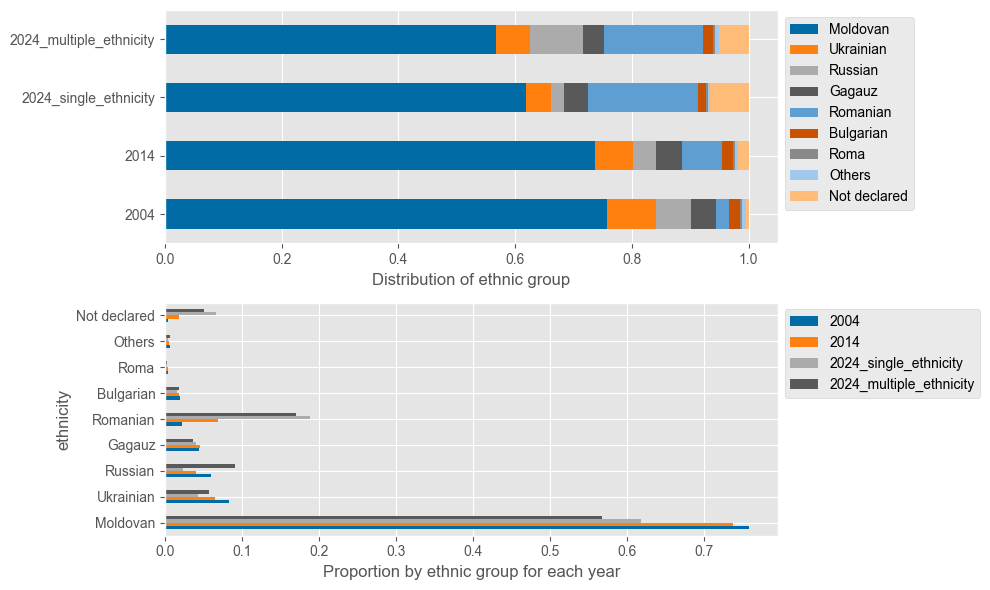

In [91]:
# Example code for obtaining 'Total Response Grouping'

# Preparing df for plotting

df = df.drop('ethnicity', axis = 1)
df = df.loc[:, :"2024"].apply(lambda x: x /  sum(x))
df = pd.merge(df,df_counts[['ethnicity','2024_multiple_p']],  left_on = "ethnicity", right_on = "ethnicity")
df = df.rename(columns = {"2024":"2024_single_ethnicity", '2024_multiple_p':'2024_multiple_ethnicity'})
df.index = df['ethnicity']
df = df.drop('ethnicity', axis = 1)

# Creating the plot
# plt.style.use('seaborn-v0_8-dark')
plt.style.use('tableau-colorblind10')

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10,6)) 

df.T.plot(ax = ax1, kind = 'barh', stacked = True)
df.plot(ax = ax2, kind = 'barh')

ax1.set_xlabel("Distribution of ethnic group")
ax2.set_xlabel("Proportion by ethnic group for each year")

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

The following table shows the differences between allowing multiple ethnic identites as opposed to allowing only for a single identity.

In [92]:
# Calculating relative changes between 2024 single identity and 2024 multiple identity simulations
df['rel_change_single_multiple'] = (df['2024_multiple_ethnicity'] - df['2024_single_ethnicity']) / df['2024_single_ethnicity'] * 100
df['rel_change_single_multiple']

ethnicity
Moldovan         -8.240459
Ukrainian        33.941855
Russian         293.122180
Gagauz           -9.973223
Romanian         -9.648741
Bulgarian        21.406280
Roma             -5.479753
Others          102.007885
Not declared    -23.156819
Name: rel_change_single_multiple, dtype: float64

### Single and Combination Grouping

In order to demonstrate what single and combination grouping looks like in practice, we can again use our simulated and hypothetical data for Moldova in 2024. As noted above, this approach retains the heterogeniety of society best by grouping the various permutations of identity combintations as they are reported. The main issue is that there can be challenging number of permutations that are not intiuitive for data users.

In our hypothetical sample, we have 57 different response groupings. This is unpractical and a "commonly practiced solution is to aggregate combinations with small cell counts into broader categories as appropriate (e.g., “other dual combinations”, “three or more ethnic groups”, or sometimes a single “mixed” category; Statistics New Zealand 2005) Yao 2021"

> Important here: The order of responses can be disregarded for grouping, unless the question specifically asked to provide a prioritization of identities. However, even in that case, some respondents may not provide a prioritization and treatment of the data becomes very challenging.

In [93]:
# Converting tuples to sets in order to disregard ordering
samples_df['identity_set'] = samples_df['identity_list'].apply(lambda x: set(x))

# Flatten the list of sets and count the values
counter = Counter([item for sublist in samples_df['identity_set'].tolist() for item in sublist])

# Create a summary list of all possible permutations
single_combination = samples_df['identity_set'].value_counts()


In [94]:
len(single_combination)

57

In [95]:
single_combination

{Moldovan}                                             1189388
{Moldovan, Romanian}                                    524952
{Russian, Moldovan}                                     219328
{Not declared}                                          195260
{Ukrainian, Moldovan}                                   121406
{Romanian}                                               84581
{Gagauz}                                                 77948
{Ukrainian}                                              34843
{Gagauz, Moldovan}                                       32309
{Russian}                                                27513
{Russian, Ukrainian}                                     23975
{Moldovan, Bulgarian}                                    22727
{Bulgarian}                                              17039
{Russian, Gagauz}                                        16839
{Russian, Moldovan, Romanian}                            13738
{Russian, Bulgarian}                                   

In [96]:
# Determine the threshold
threshold = 10000

# Create a mask for the values that are below the threshold
mask = single_combination < threshold

# Calculate the sum of the values that are below the threshold
sum_below_threshold = single_combination[mask].sum()

# Remove the entries below the threshold
single_combination = single_combination[~mask]

# Add a new entry for the sum of the values below the threshold
single_combination = single_combination.append(pd.Series({'Other combinations': sum_below_threshold}))

# Now data contains the original entries above the threshold and a single entry for the sum of those below the threshold
single_combination

C:\Users\peter\AppData\Local\Temp\ipykernel_7256\4293019699.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  single_combination = single_combination.append(pd.Series({'Other combinations': sum_below_threshold}))


{Moldovan}                       1189388
{Moldovan, Romanian}              524952
{Russian, Moldovan}               219328
{Not declared}                    195260
{Ukrainian, Moldovan}             121406
{Romanian}                         84581
{Gagauz}                           77948
{Ukrainian}                        34843
{Gagauz, Moldovan}                 32309
{Russian}                          27513
{Russian, Ukrainian}               23975
{Moldovan, Bulgarian}              22727
{Bulgarian}                        17039
{Russian, Gagauz}                  16839
{Russian, Moldovan, Romanian}      13738
{Russian, Bulgarian}               11693
Other combinations                 82662
dtype: int64

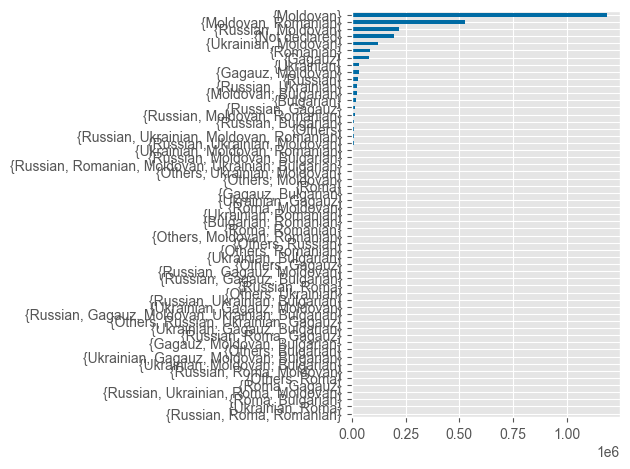

In [97]:
# Rewriting dataframe
single_combination = samples_df['identity_set'].value_counts()


fig, ax = plt.subplots()

single_combination.sort_values(ascending = True).plot(ax = ax, kind = 'barh')

plt.tight_layout()

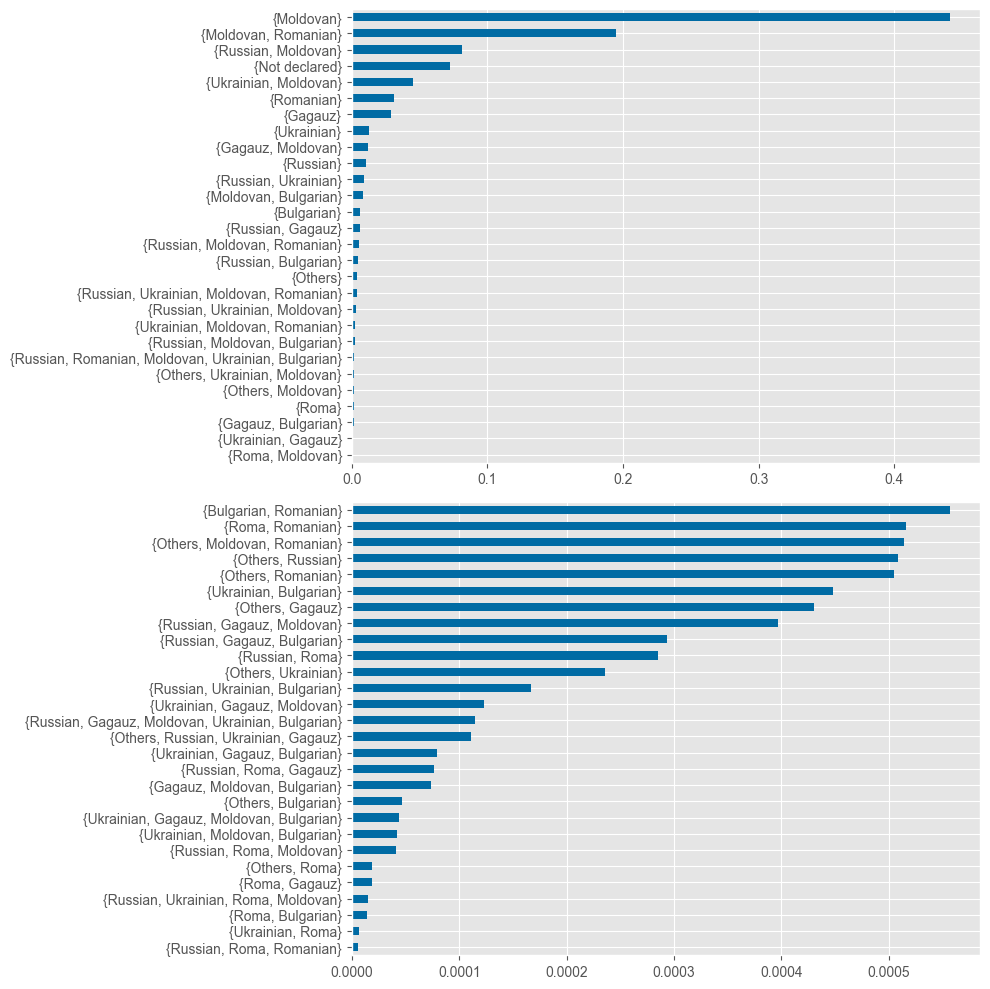

In [98]:
df_len = round(len(samples_df['identity_set'].value_counts())/2)

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (10,10))

samples_df['identity_set'].value_counts(normalize = True).sort_values(ascending = True).tail(df_len).plot(ax = ax1, kind = 'barh')
samples_df['identity_set'].value_counts(normalize = True).sort_values(ascending = True).head(df_len).plot(ax = ax2, kind = 'barh')

plt.tight_layout()

## Approach 2: Reduction Methods

Self-Prioritization and administrative-prioritization

In [108]:
# Overwrite df_e_ethnicity_grouped with fresh data
df_e_ethnicity_grouped = df_e_ethnicity.groupby('ETHN-GROUP').sum()

# Create new column names and rename them
new_col_names = vars_e.iloc[13:22].to_dict()['text']
new_col_names = {old: new.split(' - ')[1]
                 for old, new in new_col_names.items()}
df_e_ethnicity_grouped.rename(columns=new_col_names, inplace=True)
# Address faulty raw data that mixes up Q2_08 and Q2_09 with wrong translation.
df_e_ethnicity_grouped.rename(
    columns={'No else': 'Others', "Other": "None"}, inplace=True)

# Substituting 'None' answer with `ETHN-GROUP` in order to better visualize persons who only indicated one ethnic group.
for i in df_e_ethnicity_grouped.index:
    df_e_ethnicity_grouped.loc[i, i] = df_e_ethnicity_grouped.loc[i, 'None']
# Drop the now obsolete 'None' variable
df_e_ethnicity_grouped = df_e_ethnicity_grouped.drop(['None'], axis=1)

# Simulating two more sample clusters for "Others" and "Not declared" based on 2024 population estimate, as Ethnobarometer does not yield this information.
others = 400 
not_declared = 400
df_e_ethnicity_grouped.loc['Others','Others'] = others
df_e_ethnicity_grouped.loc['Not declared','Not declared'] = not_declared
df_e_ethnicity_grouped.replace(np.nan, 0, inplace = True)

# Adjust cluster sample size to reflect 2024 population estimate
for group in df_e_ethnicity_grouped.index:
    df_e_ethnicity_grouped.loc[group] = df_e_ethnicity_grouped.loc[group].apply(lambda x: x * df.loc[group]['2024_single_ethnicity'])
    
# Getting proportions via colum-wise operation
df_e_ethnicity_grouped_column = df_e_ethnicity_grouped.div(
    df_e_ethnicity_grouped.sum(axis=1), axis=0)

df_e_ethnicity_grouped_column

,Moldovan,Romanian,Russian,Ukrainian,Bulgarian,Gagauz,Roma,Others,Not declared
ETHN-GROUP,,,,,,,,,
Bulgarian,0.320276,0.002304,0.253456,0.036866,0.345622,0.039171,0.000000,0.002304,0.0
Gagauz,0.163415,0.000000,0.143902,0.014634,0.024390,0.641463,0.000000,0.012195,0.0
Moldovan,0.625000,0.194712,0.117788,0.040865,0.009615,0.007212,0.000000,0.004808,0.0
Roma,0.297821,0.012107,0.101695,0.007264,0.004843,0.009685,0.559322,0.007264,0.0
Romanian,0.669951,0.300493,0.000000,0.009852,0.004926,0.000000,0.004926,0.009852,0.0
Russian,0.427536,0.000000,0.386473,0.108696,0.028986,0.024155,0.004831,0.019324,0.0
Ukrainian,0.541860,0.006977,0.176744,0.255814,0.002326,0.011628,0.000000,0.004651,0.0
Others,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
Not declared,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


Text(0.5, 58.7222222222222, 'Test')

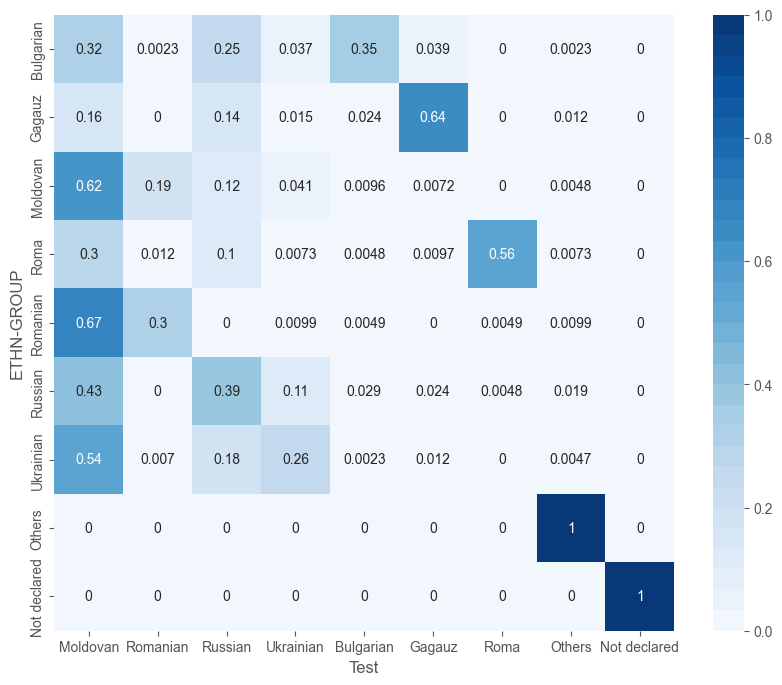

In [107]:
# Create a heatmap of the relationship between main ethnic group and other ethnic groups

fig, ax = plt.subplots(figsize = (10,8))
colormap = sns.color_palette("Blues",30) #"YlGnBu"

sns.heatmap(df_e_ethnicity_grouped_column, annot=True, cmap=colormap, ax = ax)

ax.set_xlabel("Test")

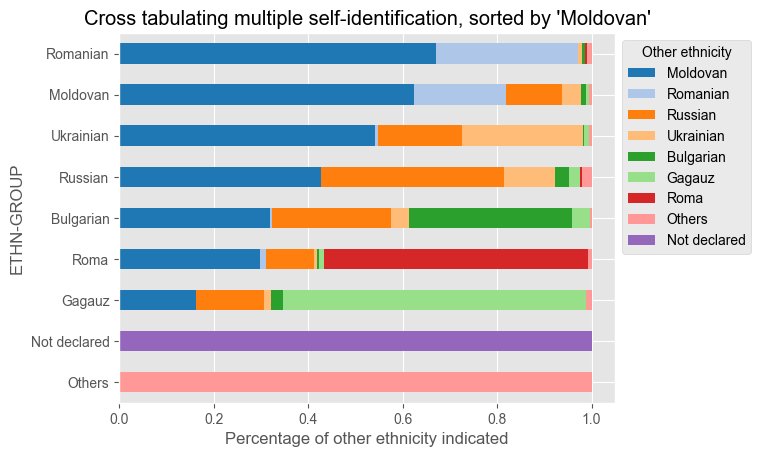

In [106]:
# Create figure
fig, ax = plt.subplots()

plt.style.use('ggplot')

colors = sns.color_palette('tab20')

df_e_ethnicity_grouped_column.sort_values('Moldovan').plot(
    ax=ax, kind='barh', stacked=True, color=colors)
ax.set_xlabel("Percentage of other ethnicity indicated")
ax.set_title(
    "Cross tabulating multiple self-identification, sorted by 'Moldovan'")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Other ethnicity")

# # Adding the values
# for p in ax.patches:
#     left, bottom, width, height = p.get_bbox().bounds
#     if width > 0:
#         ax.annotate(f'{width:.3f}', xy=(left+width/2, bottom+height/2),
#                     xytext=(0,0), textcoords='offset points', ha='center', va='center')

In [29]:
# Calculating the proportion

df_p = pd.DataFrame()

df_p[['2004', '2014', '2024']] = df[[
    '2004', '2014', '2024_single_ethnicity']].apply(lambda x: x/x.sum())
df_p = df_p.melt(ignore_index = False, var_name = "year")
df_p_total_2024['ethnicity'] = df_p_total_2024.index
df_p_total_2024 = df_p_total_2024.melt(ignore_index = False, var_name = "year")
df_p_total_2024['year'] = "2024_multiple"

NameError: name 'df_p_total_2024' is not defined

In [ ]:
# Plotting
import matplotlib.patches as mpatches

fig, (ax,ax2) = plt.subplots(2, figsize=(15,10))

colors = sns.color_palette('tab20')

df_p.loc[df_p_total_2024.index,:].plot(ax=ax, kind='barh', alpha=0.2, width = 0.3, legend = True)
df_p_total_2024.plot(ax=ax, kind='barh', stacked=True, color=colors, position=-1, width=0.2, legend = True)

df_p.loc[['Roma'],:].plot(ax=ax2, kind='barh', alpha=0.2, width = 0.3, legend = True)
df_p_total_2024.loc[['Roma'],:].plot(ax=ax2, kind='barh', stacked=True, color=colors, position=-1, width=0.2, legend = True)


In [ ]:
# Generating a small random sample of multiple identities, with a maxium of 3 identities. We assume that the probability for a person to indicate a single ethnicity is 0.7, for two ethnicities it is 0.25, for 3 identities it is 0.05. For a draw that has 'nu a declarat etnia' as the fist item, the observation will be designated as 'nu a declarat etnia'. The probabilities are not based on any evidence.

random_multiple_ethnicity = []

# The range could be any given sample size.
for i in range(1000):
    while True:
        drawn_ethnicity = np.random.choice(df['ethnicity'],
                                           size=random.choices(
                                               [1, 2, 3], weights=[0.7, 0.25, 0.05]),
                                           replace=False,
                                           p=df['2024'])
        # Check if the particular ethnicity is drawn
        if 'nu a declarat etnia' in drawn_ethnicity[0]:
            random_multiple_ethnicity.append(['nu a declarat etnia'])
            break
        else:
            random_multiple_ethnicity.append(drawn_ethnicity)
            break


In [ ]:
# Generating a small random sample of multiple identities, with a maxium of 3 identities. We assume that the probability for a person to indicate a single ethnicity is 0.7, for two ethnicities it is 0.25, for 3 identities it is 0.05. For a draw that has 'nu a declarat etnia' as the fist item, the observation will be designated as 'nu a declarat etnia'. The probabilities are not based on any evidence.

random_multiple_ethnicity = []

# The range could be any given sample size.
for i in range(1000):
    while True:
        drawn_ethnicity = np.random.choice(df['ethnicity'],
                                           size=random.choices(
                                               [1, 2, 3], weights=[0.7, 0.25, 0.05]),
                                           replace=False,
                                           p=df['2024'])
        # Check if the particular ethnicity is drawn
        if 'nu a declarat etnia' in drawn_ethnicity[0]:
            random_multiple_ethnicity.append(['nu a declarat etnia'])
            break
        else:
            random_multiple_ethnicity.append(drawn_ethnicity)
            break


##### Using 2014 proportions

# Language
## Census-variable `mother tongue`

In [ ]:

df = pd.read_excel('MLD_census_ethnicity.xls', sheet_name="8")
# Cleaning dataset
df = df.iloc[10:27, 0:3]
df.columns = ['native', '2004', '2014']
df = df[df['2004'].notna()]
df.reset_index(drop=True, inplace=True)
df['native'][7] = df['native'][7][:34]


In [ ]:
df


In [ ]:
fig, ax = plt.subplots()

df.plot(ax=ax, kind="barh", x='native', stacked=True,
        color=sns.color_palette("husl", 9))
ax.legend(bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)
ax.set_title(
    "Native language speakrs and their preferred usual Language based on Census 2014")
ax.set_ylabel("Native Language")


## Census-variable `usual language`

Investigate the sheet on mother tongue and native language: Gagauz mother tongue indicates 64% Gagauz as native language

In [ ]:

df = pd.read_excel('MLD_census_ethnicity.xls', sheet_name="9")
# Cleaning dataset
df = df.iloc[10:27, 0:3]
df.columns = ['usual', '2004', '2014']
df = df[df['2004'].notna()]
df.reset_index(drop=True, inplace=True)
df['usual'][7] = df['usual'][7][:34]


In [ ]:
df.plot(kind="barh", x='usual')


## `Native` and `Usual`

In [ ]:

df = pd.read_excel('MLD_census_ethnicity.xls', sheet_name="10-11")


In [ ]:
cols = df.iloc[4].values
df = pd.DataFrame(df.iloc[6:15])


In [ ]:
df.columns = ['native',
              'total',
              'Moldovenească',
              'Ucraineană',
              'Rusă',
              'Găgăuză',
              'Română',
              'Bulgară',
              'Romani',
              'Alte limbi',
              'Nedeclarată']


In [ ]:
df = df.drop(columns="total")


In [ ]:
df.plot(kind="bar", stacked=True, x='native')


In [ ]:
# Cleaning dataset
df = df.iloc[10:27, 0:3]
df.columns = ['usual', '2004', '2014']
df = df[df['2004'].notna()]
df.reset_index(drop=True, inplace=True)
df['usual'][7] = df['usual'][7][:34]a


In [ ]:
df


In [ ]:
import squarify
import matplotlib.pyplot as plt

# Sample data
ethnicities = ["Moldoveni", "Ucraineni", "Ruşi",
               "Găgăuzi", "Rom", "Bulgari", "Ro", "Alte", "decl"]
populations = [2564849, 282406, 201218,
               147500, 73276, 65662, 12271, 22130, 14020]

# Create a data frame
df = pd.DataFrame({'ethnicity': ethnicities, 'population': populations})

# Normalizing the data to make it suitable for plotting
df['norm'] = df['population'] / df['population'].sum()

# Using squarify to create a square-ful layout
rects = squarify.plot(sizes=df['norm'], label=df['ethnicity'], alpha=.6)

# Add title and axis labels
plt.title("Identity tree map of all individuals having indicated \"Moldoveni\" as one of their responses",
          fontsize=10, fontweight="bold")

# Remove axes
plt.axis('off')

# Ensure the plot is


# Diversity mapping

The United States Census Bureau calculates a [Diversity Index](https://www.census.gov/library/stories/2021/08/2020-united-states-population-more-racially-ethnically-diverse-than-2010.html/ "Diversity Index")

>The Diversity Index (DI) is the probability that two people chosen at random will be from different racial and ethnic groups. The DI is bounded between 0 and 1. A value of 0 indicates that everyone in the population has the same racial and ethnic characteristics. A value close to 1 indicates that almost everyone in the population has different racial and ethnic characteristics.

In [ ]:
# Load shapefiles

gdf = gpd.read_file(
    '../../data/gis/mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm1_unhcr_20220510.shp')


In [ ]:
# Load geographical data from census


In [ ]:
# Load raw data downloaded from NBS
df = pd.read_excel(response.content, sheet_name="12")


In [ ]:
arr = df.iloc[4, 0:10].astype(str).str.split('\n').apply(lambda x: x[0]).values
arr[0] = "district"
arr[1] = "pop"
df.columns = arr


In [ ]:
# Cleaning dataset
df = df.iloc[6:41, 0:10]


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


In [ ]:
df['district_en'] = df['district'].apply(lambda x: process.extract(
    x, choices=gdf['ADM1_EN'].values, scorer=fuzz.token_sort_ratio)[0][0])


In [ ]:
gdf_m = gdf.merge(df, how="left", left_on="ADM1_EN", right_on="district_en")

In [ ]:
gdf_m.columns

In [ ]:
# Cleaning data and formatting values to float for mapping
gdf_m = gdf_m.replace('-', np.nan)
gdf_m.loc[:, 'pop':'Alte etnii'] = gdf_m.loc[:, 'pop':'Alte etnii'].apply(
    lambda x: x.astype(float), axis=1)


In [ ]:
# # Logarithm
# gdf_m.loc[:,'pop':'Alte etnii'] = gdf_m.loc[:,'pop':'Alte etnii'].apply(lambda x: np.log(x))


In [ ]:
gdf_m = gdf_m.to_crs(epsg=3857)


In [ ]:
# import contextily as ctx

# providers = ctx.providers.flatten()

# selection = ['OpenStreetMap.Mapnik',
#              'OpenTopoMap',
#              'Stamen.Toner',
#              'Stamen.TonerLite',
#              'Stamen.Terrain',
#              'Stamen.TerrainBackground',
#              'Stamen.Watercolor',
#              'NASAGIBS.ViirsEarthAtNight2012',
#              'CartoDB.Positron',
#              'CartoDB.Voyager'
#             ]

# fig, axs = plt.subplots(2, 5, figsize=(25, 10))

# axs = axs.flatten()
# for name, ax in zip(selection, axs):
#     gdf_m.plot(ax = ax, column = "Moldoveni", cmap="BuPu", legend = True, alpha = .5)
#     ctx.add_basemap(ax, source=providers[name])

In [ ]:
df.columns[1:10]


In [ ]:

providers = ctx.providers.flatten()

selection = df.columns[2:10]

n = len(selection)
ncols = 3  # You can adjust this as you like
nrows = np.ceil(n / ncols).astype(int)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9))

# fig.suptitle("Mapped logarithmic distribution of population by ethnic belonging in the 2014 Census of Moldova")

fig.tight_layout()

axs = axs.flatten()
for name, ax in zip(selection, axs):
    gdf_m.plot(ax=ax, color='black', edgecolor='black')
    gdf_m.plot(ax=ax, column=name, cmap="Purples", legend=True,
               legend_kwds={'shrink': 0.3}, alpha=.8)
    ax.set_title(name, loc="left")
    ax.set_axis_off()
    # ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

for ax in axs[n:]:
    ax.remove()

fig.savefig('map.png')


In [ ]:
gdf_m.index = gdf_m.district


In [ ]:
gdf_m = gdf_m.to_json()


In [ ]:
import plotly.express as px
import json

fig = px.choropleth(gdf_m, geojson=gdf_m, color='Moldoveni')

fig.update_geos(showcountries=False)
fig.show()


# Other data from the National Bureau of Statistics

In [ ]:
# Other indicators

import json

# Mean monthly salary
url = "https://statbank.statistica.md:443/PxWeb/api/v1/ro/30 Statistica sociala/03 FM/SAL010/serii anuale/SAL010400reg.px"

query = {
    "query": [
        {
            "code": "Raioane/Regiuni",
            "selection": {
                "filter": "item",
                "values": [
                    "34",
                    "40",
                    "35",
                    "3",
                    "10",
                    "11",
                    "13",
                    "14",
                    "15",
                    "16",
                    "21",
                    "24",
                    "25",
                    "26",
                    "41",
                    "1",
                    "6",
                    "9",
                    "12",
                    "17",
                    "18",
                    "20",
                    "22",
                    "23",
                    "27",
                    "28",
                    "31",
                    "32",
                    "42",
                    "2",
                    "4",
                    "5",
                    "7",
                    "8",
                    "19",
                    "29",
                    "30",
                    "33"
                ]
            }
        },
        {
            "code": "Ani",
            "selection": {
                "filter": "item",
                "values": [
                    "2011",
                    "2012",
                    "2013",
                    "2014",
                    "2015",
                    "2016",
                    "2017",
                    "2018",
                    "2019",
                    "2020",
                    "2021"
                ]
            }
        },
        {
            "code": "Sexe",
            "selection": {
                "filter": "item",
                "values": [
                    "1",
                    "2"
                ]
            }
        }
    ],
    "response": {
        "format": "px"
    }
}


# Crimes
url_crimes = "https://statbank.statistica.md:443/PxWeb/api/v1/ro/30 Statistica sociala/12 JUS/JUS010/JUS010600reg.px"

query_crimes = {
    "query": [
        {
            "code": "Regiuni/Raioane",
            "selection": {
                "filter": "item",
                "values": [
                    "0",
                    "34",
                    "40",
                    "35",
                    "3",
                    "10",
                    "11",
                    "13",
                    "14",
                    "15",
                    "16",
                    "21",
                    "24",
                    "25",
                    "26",
                    "41",
                    "1",
                    "6",
                    "9",
                    "12",
                    "17",
                    "18",
                    "20",
                    "22",
                    "23",
                    "27",
                    "28",
                    "31",
                    "32",
                    "42",
                    "2",
                    "4",
                    "5",
                    "7",
                    "8",
                    "19",
                    "29",
                    "30",
                    "33",
                    "00"
                ]
            }
        }
    ],
    "response": {
        "format": "px"
    }
}


In [ ]:
# Salary
response = requests.post(url=url, json=query)

# Creating a temporary file
with open('temp.px', 'wb') as file:
    file.write(response.content)

px = pyaxis.parse('temp.px', encoding='ISO-8859-2')

# Deleting the temporary file
os.remove('temp.px')


In [ ]:
# Crimes
response = requests.post(url=url_crimes, json=query_crimes)

# Creating a temporary file
with open('temp.px', 'wb') as file:
    file.write(response.content)

px = pyaxis.parse('temp.px', encoding='ISO-8859-2')

# Deleting the temporary file
os.remove('temp.px')


In [ ]:
df = px['DATA']


In [ ]:
df.columns


In [ ]:
df['DATA'] = df['DATA'].replace('"..."', np.nan).replace(
    '', np.nan).replace('"-"', np.nan).apply(float)


In [ ]:
df['Ani'] = pd.to_datetime(df['Ani'])


In [ ]:
df = df.groupby(['Ani', 'Gravitatea infractiunii']).sum("DATA").reset_index()


In [ ]:
df["DATA"] = df["DATA"].apply(np.log)


In [ ]:
sns.lineplot(data=df, x="Ani", y="DATA", hue="Gravitatea infractiunii")


In [ ]:
df[df['Ani'] == "2021"].groupby(['Raioane/Regiuni']).mean().sort_values(
    by='DATA').plot(kind="barh", figsize=(10, 15), title=str(px['METADATA']['TITLE']))


In [ ]:
# Compute the mean for each year
mean_2014 = df[df['Ani'] == "2014"].groupby('Raioane/Regiuni').mean()
mean_2021 = df[df['Ani'] == "2021"].groupby('Raioane/Regiuni').mean()

# Join the two dataframes into a single one, using the index
joined_df = mean_2014.join(mean_2021, lsuffix='_2014', rsuffix='_2021')

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(joined_df['DATA_2014'], joined_df['DATA_2021'])
plt.xlabel('Mean value (2014)')
plt.ylabel('Mean value (2021)')
plt.title('Scatter plot of mean values in 2014 vs 2021')

plt.show()


# Annex: Thinking about Multiple Identity in Statistical Terms

It is helpful to think about the various possible combinations of multiple identities as $k$ mutually exclusive outcomes in a *multinomial distribution*, where each outcome (i.e. multiple identity combination) $k$ has a constant probability $p_1,...,p_k$.

>The probability mass function of the multinomial distribution is given by:

$$ P(X_1=x_1, \ldots X_k=x_k) = \frac{n!}{(x_1!x_2! \ldots x_k!)} p_1^{x_1} \ldots p_k^{x_k} $$

Assuming that we know all probabilities for all mutually exclusive possible combinations of multiple identities occuring in society, we can then use the multinomial distribution to simulate $n$ independent trials (i.e. persons).

1. One challenge of using the multinomial distribution relates to the assumption that there are a finite number of possible outcomes for each trial, and the likelihood of any event occurring is constant throughout the experiment. However, at least in theory, there is an *infinite* number of possible combinations of identities, in line with the primacy of voluntary self-identification. As it is impossible to know the probabilities of all combinations, we can subsume all unknown combinations into the category "Others", which is:

$$ 1 - \sum{p_1^{known} \ldots p_i^{known}} $$

2. The multinomial distribution also requires independence of outcomes. However, we know that identities are often dependent on each other. This dependence therefore needs to be reflected in the probabilities of mutually exclusive outcomes.

> Using multinomial distribution is but one option to deal with multiple identities in statistical terms. For more complex representations, mixed membership models may be appropriate allowing for assigning relative proportions between identities. However, this requires complex, and (more) challenging data.



In [ ]:
### CODE GARAGE

# # Using sci-kit learn
# X = np.array([2004, 2014]).reshape(-1, 1)

# for i in range(df.shape[0]):
#     Y = df.loc[i, ['2004','2014']].values.reshape(-1,1)
#     model.fit(X, Y)
#     df.loc[i, ['2024_linear']] = model.predict([[2024]])[0][0]

# Using only numpy
# X = np.array([2004, 2014])
# Y = df.loc[0, ['2004','2014']].values
# X_mean = np.mean(X)
# Y_mean = np.mean(Y)
# b = np.sum((X - X_mean) * (Y - Y_mean)) / np.sum((X - X_mean)**2)
# a = Y_mean - b * X_mean
# a + b * 2024

# # Polynomial regression
# years = np.array([2004, 2014]).reshape(-1, 1)
# poly = PolynomialFeatures(degree=2)
# years_poly = poly.fit_transform(years)

# for i in range(df.shape[0]):
#     pop = df.loc[i, ['2004', '2014']].values.reshape(-1, 1)
#     model = LinearRegression().fit(years_poly, pop)
#     df.loc[i, ['2024_poly']] =  model.predict(poly.transform(np.array(2024).reshape(-1, 1)))[0][0].round(0)
